## 1. Imports and definitions

In [54]:
import pandas as pd
import numpy as np

# Modelling and Forecasting
# ==============================================================================
import sklearn
import skforecast
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.model_selection_multiseries import select_features_multiseries
from skforecast.plot import set_dark_theme
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict

# Viz
# ==============================================================================
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
plt.style.use('seaborn-v0_8-darkgrid')


In [55]:
# Cliclical encoding of direction features
# ==============================================================================
def cyclical_encoding(data: pd.Series, cycle_length: int) -> pd.DataFrame:
    """
    Encode a cyclical feature with two new features sine and cosine.
    The minimum value of the feature is assumed to be 0. The maximum value
    of the feature is passed as an argument.
      
    Parameters
    ----------
    data : pd.Series
        Series with the feature to encode.
    cycle_length : int
        The length of the cycle. For example, 12 for months, 24 for hours, etc.
        This value is used to calculate the angle of the sin and cos.

    Returns
    -------
    result : pd.DataFrame
        Dataframe with the two new features sin and cos.

    """

    sin = np.sin(2 * np.pi * data/cycle_length)
    cos = np.cos(2 * np.pi * data/cycle_length)
    result =  pd.DataFrame({
                  f"{data.name}_sin": sin,
                  f"{data.name}_cos": cos
              })

    return result


In [56]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

class SineCosineEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cycle_length=360):
        self.cycle_length = cycle_length
        self.transform_storage = {}
        self.last_series_name = None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            self.last_series_name = X.columns[0]
            self.series_index = X.index
            X = X.iloc[:, 0]
        elif isinstance(X, pd.Series):
            self.last_series_name = X.name
            self.series_index = X.index
        else:
            raise ValueError("Input must be a pandas DataFrame or Series.")
        
        X = np.asarray(X).ravel()
        sine = np.sin(2 * np.pi * X / self.cycle_length)
        cosine = np.cos(2 * np.pi * X / self.cycle_length)
        
        # Store the cosine components by series name
        self.transform_storage[self.last_series_name] = cosine
        
        return pd.DataFrame({self.last_series_name: sine}, index=self.series_index)

    def inverse_transform(self, X):
        if self.last_series_name not in self.transform_storage:
            raise ValueError("Transformation has not been applied yet for the series.")

        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame.")
        
        series_name = X.columns[0]
        if series_name not in self.transform_storage:
            raise ValueError(f"Transformation has not been applied yet for the series '{series_name}'.")

        sine = np.asarray(X[series_name]).ravel()
        cosine = self.transform_storage[series_name]
        
        if len(sine) > len(cosine):
            raise ValueError(f"Shape mismatch: sine length is {len(sine)}, but expected length is {len(cosine)}.")
        
        # Trim cosine to match the length of sine
        cosine = cosine[:len(sine)]
        
        # Calculate angles from sine and cosine
        angles = np.arctan2(sine, cosine)
        return pd.Series(angles * self.cycle_length / (2 * np.pi), index=X.index, name=series_name)

    def get_feature_names_out(self, input_features=None):
        return [self.last_series_name if self.last_series_name else 'sine_component']


## 2. Read and transform data 

In [57]:
# Read data in
data_dir = 'Data/spain/four years'
file = '/spain_data_all.csv'

df = pd.read_csv(data_dir + file)
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index(keys = 'datetime', inplace=True)
df = df.asfreq('H')

df.head()

,wave_height,wave_period,wave_direction,current_speed,current_direction,water_temp,wind_speed,wind_direction
datetime,,,,,,,,
2020-06-18 00:00:00,0.78,4.92,333.0,0.212,105.55,17.592,1.82,232.0
2020-06-18 01:00:00,0.76,5.06,334.0,0.206,100.62,17.560,1.40,230.0
2020-06-18 02:00:00,0.74,5.16,334.0,0.203,95.08,17.536,1.37,251.0
2020-06-18 03:00:00,0.73,5.22,335.0,0.206,90.01,17.520,1.46,227.0
2020-06-18 04:00:00,0.73,5.28,336.0,0.210,87.01,17.512,1.88,228.0


In [58]:
# Slice off target variables
target_vars = ['wave_height', 'wave_period', 'wave_direction']
df_target = df[target_vars].copy()
df_target

,wave_height,wave_period,wave_direction
datetime,,,
2020-06-18 00:00:00,0.78,4.92,333.0
2020-06-18 01:00:00,0.76,5.06,334.0
2020-06-18 02:00:00,0.74,5.16,334.0
2020-06-18 03:00:00,0.73,5.22,335.0
2020-06-18 04:00:00,0.73,5.28,336.0
...,...,...,...
2024-06-18 19:00:00,0.93,3.61,21.0
2024-06-18 20:00:00,0.92,3.82,21.0
2024-06-18 21:00:00,0.86,4.08,19.0


In [59]:
# # Transform wave direction variable into a cyclical variable, as the original variable is in degrees, from 0 to 360
# direction_cycle = cyclical_encoding(df['wave_direction'], cycle_length=360)

# # Replace direction variable with one of the produced variables. Could be either sine or cosine, we are indifferent
# df_target['wave_direction_sine'] = direction_cycle['wave_direction_sin']
# df_target.drop(columns = ['wave_direction'], inplace = True)
# df_target


In [60]:
df_target.isnull().value_counts()

wave_height  wave_period  wave_direction
False        False        False             35088
Name: count, dtype: int64

In [74]:
# Train-test split
# ==============================================================================
one_month = (-1)*30*24 # One month
two_months = (-1)*60*24 # Two months

end_val = two_months + two_months + one_month
end_train = end_val + two_months + two_months + one_month 

df_train = df_target.iloc[:end_train].copy()
df_val = df_target.iloc[end_train:end_val].copy()
df_test = df_target.iloc[end_val:].copy()

print(f"Train dates      : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Validation dates : {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")
print(f"Test dates       : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Train dates      : 2020-06-18 00:00:00 --- 2023-08-23 23:00:00  (n=27888)
Validation dates : 2023-08-24 00:00:00 --- 2024-01-20 23:00:00  (n=3600)
Test dates       : 2024-01-21 00:00:00 --- 2024-06-18 23:00:00  (n=3600)


## 3. Modelling

In [75]:
# Train and backtest a model for all items: ForecasterAutoregMultiSeries
# ======================================================================================
items = list(df_target.columns)

# Define forecaster
forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = LGBMRegressor(random_state=42),
                    lags               = 24,
                    encoding           = 'ordinal'
                  #   transformer_series = {'wave_direction':SineCosineEncoder()}
                )
# Backtesting forecaster for all items
multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster            = forecaster_ms,
                                       series                = df_target,
                                       levels                = None,
                                       steps                 = 12,
                                       metric                = 'mean_absolute_error',
                                    #    add_aggregated_metric = False,
                                       initial_train_size    = len(df_train) + len(df_val),
                                       refit                 = False,
                                       fixed_train_size      = False,
                                       verbose               = False,
                                       show_progress         = True 
                                    )
# Results
display(multi_series_mae.head(3))
print('')
display(predictions_ms.head(3))



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6123
[LightGBM] [Info] Number of data points in the train set: 94392, number of used features: 25
[LightGBM] [Info] Start training from score 0.000105


  0%|          | 0/300 [00:00<?, ?it/s]

,levels,mean_absolute_error
0,wave_height,0.185216
1,wave_period,0.660929
2,wave_direction,34.284937


,wave_height,wave_period,wave_direction
2024-01-21 00:00:00,0.718421,4.936556,34.187286
2024-01-21 01:00:00,0.718421,4.936556,34.187286
2024-01-21 02:00:00,0.718421,4.938014,33.351236


In [76]:
predictions_ms

,wave_height,wave_period,wave_direction
2024-01-21 00:00:00,0.718421,4.936556,34.187286
2024-01-21 01:00:00,0.718421,4.936556,34.187286
2024-01-21 02:00:00,0.718421,4.938014,33.351236
2024-01-21 03:00:00,0.718421,4.938014,33.351236
2024-01-21 04:00:00,0.718421,4.938014,33.351236
...,...,...,...
2024-06-18 19:00:00,0.787350,4.317689,26.149279
2024-06-18 20:00:00,0.787350,4.317689,26.149279
2024-06-18 21:00:00,0.787350,4.297793,25.349657
2024-06-18 22:00:00,0.787350,4.297793,25.134733


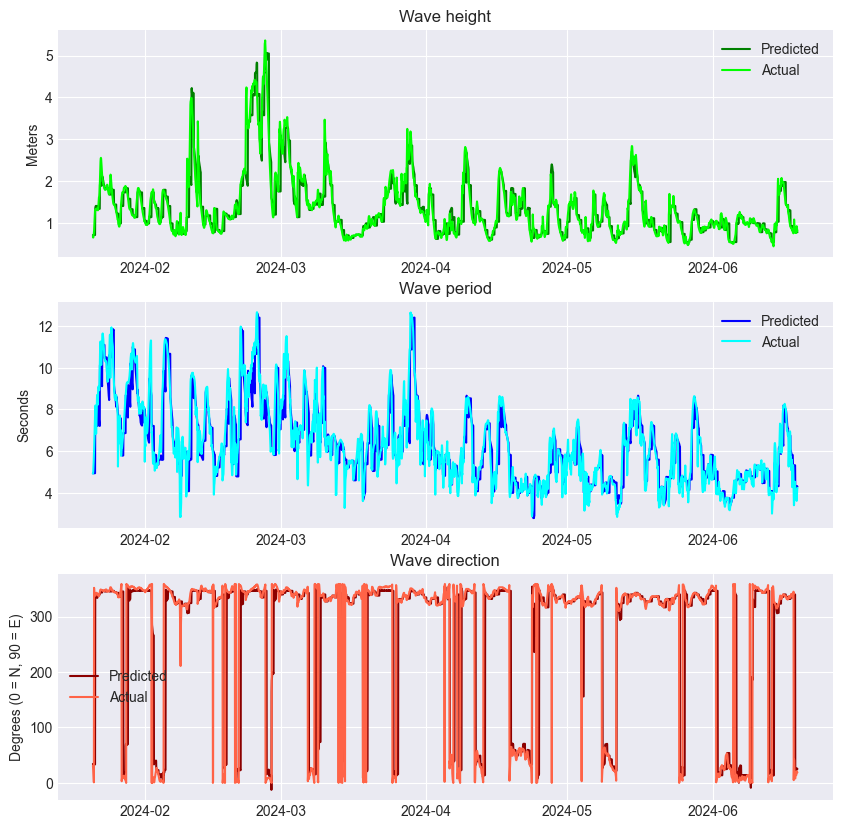

In [77]:
# Plot predictions vs real value
# ======================================================================================
fig, ax = plt.subplots(3, 1, figsize = (10,10))

ax[0].plot(predictions_ms['wave_height'], color = 'green', label = 'Predicted')
ax[0].plot(df_test['wave_height'], color = 'lime', label = 'Actual')
ax[0].set_ylabel('Meters')
ax[0].set_title('Wave height')

ax[1].plot(predictions_ms['wave_period'], color = 'blue', label = 'Predicted')
ax[1].plot(df_test['wave_period'], color = 'cyan', label = 'Actual')
ax[1].set_ylabel('Seconds')
ax[1].set_title('Wave period')

ax[2].plot(predictions_ms['wave_direction'], color = 'darkred', label = 'Predicted')
ax[2].plot(df_test['wave_direction'], color = 'tomato', label = 'Actual')
ax[2].set_ylabel('Degrees (0 = N, 90 = E)')
ax[2].set_title('Wave direction')

for axi in ax:
    axi.legend()

plt.show()

### 3.2 Hyperparameter search

In [78]:
# Hyperparameter search for the multi-series model and backtesting for each item
# ======================================================================================
def search_space(trial):
    search_space  = {
        'lags'          : trial.suggest_categorical('lags', [6, 12, 24, 48]),
        'n_estimators'  : trial.suggest_int('n_estimators', 600, 1200, step=50),
        'max_depth'     : trial.suggest_int('max_depth', 3, 16, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'subsample'     : trial.suggest_float('subsample', 0.1, 1, step = 0.1),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10, step = 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1., step = 0.1)
    } 

    return search_space

forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = LGBMRegressor(random_state=42),
                    lags               = 14,
                    # transformer_series = StandardScaler(),
                    encoding           = 'ordinal'
                )

results_bayesian_ms = bayesian_search_forecaster_multiseries(
                        forecaster         = forecaster_ms,
                        series             = df_target.iloc[:end_val, :],
                        levels             = None, # If None all levels are selected
                        search_space       = search_space,
                        n_trials           = 50,
                        steps              = 12,
                        metric             = 'mean_absolute_error',
                        initial_train_size = len(df_train),
                        refit              = False,
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False,
                        show_progress      = False 
                    )      

multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster             = forecaster_ms,
                                       series                 = df_target,
                                       levels                 = None, # If None all levels are selected
                                       steps                  = 7,
                                       metric                 = 'mean_absolute_error',
                                        add_aggregated_metric = False,
                                       initial_train_size     = len(df_train) + len(df_val),
                                       refit                  = False,
                                       fixed_train_size       = False,
                                       verbose                = False
                                   )

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1533
[LightGBM] [Info] Number of data points in the train set: 83646, number of used features: 7
[LightGBM] [Info] Start training from score 0.000039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [ ]:
# Results
display(multi_series_mae.head(3))
print('')
display(predictions_ms.head(3))

In [73]:
df_target.iloc[:end_val, :]

,wave_height,wave_period,wave_direction
datetime,,,
2020-06-18 00:00:00,0.78,4.92,333.0
2020-06-18 01:00:00,0.76,5.06,334.0
2020-06-18 02:00:00,0.74,5.16,334.0
2020-06-18 03:00:00,0.73,5.22,335.0
2020-06-18 04:00:00,0.73,5.28,336.0
...,...,...,...
2024-06-12 13:00:00,0.81,5.11,351.0
2024-06-12 14:00:00,0.82,5.17,352.0
2024-06-12 15:00:00,0.82,5.16,353.0
